In [1]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [2]:


import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Layer, Lambda
from sklearn.model_selection import train_test_split
import os
import imageio
import cv2
import glob2
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils


Using TensorFlow backend.


In [3]:
import glob

In [4]:
example_image = imageio.imread('example.png')

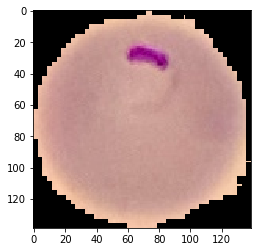

In [5]:
plt.imshow(example_image)

In [6]:
parasitized_cells = os.listdir('C:\\Users\\Thomas\\Malaria Project\\Parasitized\\')
#Importing the data for the parasitized cells

uninfected_cells = os.listdir('C:\\Users\\Thomas\\Malaria Project\\Uninfected')
#importing uninfected cell image data


In [7]:
print(len(parasitized_cells))
print(len(uninfected_cells))
#confirming all the data was put in 

13780
13780


In [8]:
data = []
labels = []

for img in parasitized_cells:
    try:
        img_read = plt.imread('C:\\Users\\Thomas\\Malaria Project\\Parasitized\\' + img)
        img_resize = cv2.resize(img_read, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        print("Error with Parasitized cell")
        
for img in uninfected_cells:
    try: 
        img_read = plt.imread('C:\\Users\\Thomas\\Malaria Project\\Uninfected\\' + img)
        img_resize = cv2.resize(img_read, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        print("Error with uninfected cell")


Error with Parasitized cell
Error with uninfected cell


### The "errors" in the above cell
Each folder has a .db file in them which cannot be read by imread.  This means that one error per folder is exactly what we are looking for

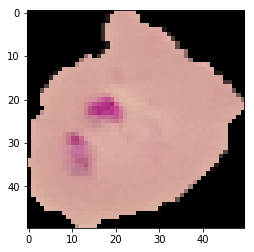

In [9]:
#Checking to see if the images were imported
plt.imshow(data[3])
plt.show()

In [10]:
image_data = np.array(data)
labels = np.array(labels)

In [11]:
#Processing the data for modeling
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [12]:
#Sanity check on labeling
import collections

labels
collections.Counter(labels)

Counter({1: 13779, 0: 13779})

In [13]:
#Train test split 
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = .2, random_state = 42)

In [14]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)

y_test  = np_utils.to_categorical(y_test, num_classes = 2)

In [15]:
print(f"Shape of training image data : {x_train.shape}")
print(f"Shape of testing image data : {x_test.shape}")
print(f"Shape of training labels : {y_train.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of training image data : (22046, 50, 50, 3)
Shape of testing image data : (5512, 50, 50, 3)
Shape of training labels : (22046, 2)
Shape of testing labels: (5512, 2)


In [16]:


import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers



### Model Creation

In [17]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [18]:
height = 50
width = 50
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
____________________

In [19]:
import keras_metrics
import tensorflow as tf

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc', recall_m])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
keras.backend.get_session().run(tf.global_variables_initializer())

In [22]:
first_model = model.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 10s 435us/step - loss: 0.6482 - acc: 0.6928 - recall_m: 0.6928
Epoch 2/20
22046/22046 [==============================] - 7s 312us/step - loss: 0.2538 - acc: 0.9067 - recall_m: 0.9067
Epoch 3/20
22046/22046 [==============================] - 7s 310us/step - loss: 0.1989 - acc: 0.9301 - recall_m: 0.9301
Epoch 4/20
22046/22046 [==============================] - 7s 312us/step - loss: 0.1905 - acc: 0.9372 - recall_m: 0.93720s - loss: 0.1908 - acc: 0.9368 - re
Epoch 5/20
22046/22046 [==============================] - 7s 311us/step - loss: 0.1805 - acc: 0.9417 - recall_m: 0.9417
Epoch 6/20
22046/22046 [==============================] - 7s 312us/step - loss: 0.1762 - acc: 0.9422 - recall_m: 0.9422
Epoch 7/20
22046/22046 [==============================] - 7s 334us/step - loss: 0.1684 - acc: 0.9462 - recall_m: 0.9462
Epoch 8/20
22046/22046 [==============================] - 7s 335us/step - loss: 0.1656 - acc: 0.9462 - recall_m: 0.9462
Epo

In [23]:
predictions = model.evaluate(x_test, y_test)


print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

5512/5512 [==============================] - 1s 235us/step
LOSS : 0.12474322024359759
ACCURACY : 0.9602685050798259


In [24]:
y_pred = model.predict(x_test)
y_pred_tensor = tf.convert_to_tensor(y_pred, np.float32)
y_test_tensor = tf.convert_to_tensor(y_test, np.float32)
sess = tf.InteractiveSession()



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

y_pred2=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, y_pred2)

array([[2658,   55],
       [ 164, 2635]], dtype=int64)

In [26]:
recall_score(y_test2, y_pred2)

0.94140764558771

In [27]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred2)))

Recall score of the model: 0.94140764558771


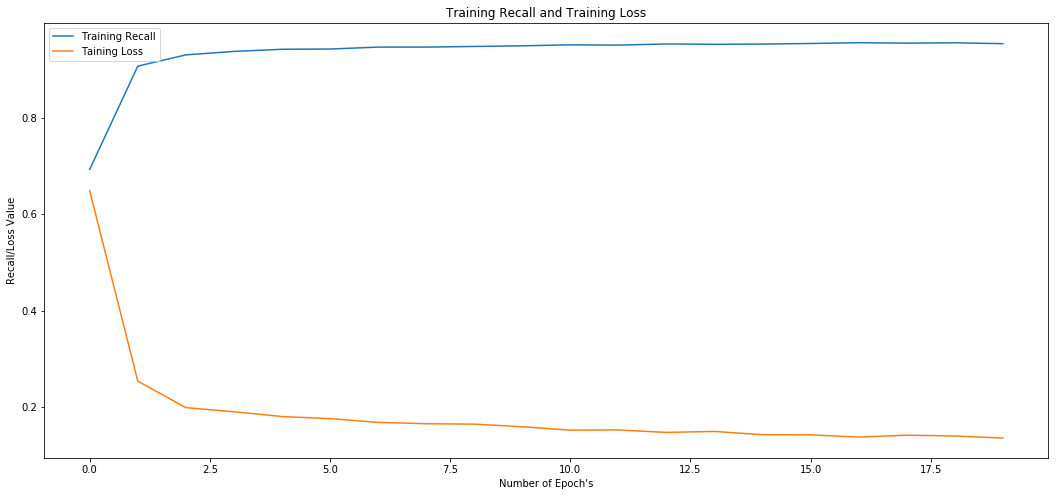

In [28]:
plt.figure(figsize = (18,8))
plt.plot(range(20), first_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), first_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Training Recall and Training Loss')
plt.legend(loc = "best")
#graphing how the accuracy and loss change over the epochs

In [29]:
from keras.preprocessing.image import ImageDataGenerator

In [30]:
train_datagen = ImageDataGenerator(#rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator() #rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = True)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [31]:
augmented_model = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [32]:

aug_optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
augmented_model.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc', recall_m])

In [33]:
history_augmented_model = augmented_model.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 23s 68ms/step - loss: 0.7112 - acc: 0.6759 - recall_m: 0.67591s - los
Epoch 2/20
344/344 [==============================] - 20s 58ms/step - loss: 0.3975 - acc: 0.8320 - recall_m: 0.8320
Epoch 3/20
344/344 [==============================] - 21s 60ms/step - loss: 0.3350 - acc: 0.8647 - recall_m: 0.86473s - loss:
Epoch 4/20
344/344 [==============================] - 20s 57ms/step - loss: 0.3085 - acc: 0.8821 - recall_m: 0.8821
Epoch 5/20
344/344 [==============================] - 20s 57ms/step - loss: 0.2990 - acc: 0.8860 - recall_m: 0.88600s - loss: 0.2987 - acc: 0
Epoch 6/20
344/344 [==============================] - 20s 59ms/step - loss: 0.2906 - acc: 0.8915 - recall_m: 0.8915
Epoch 7/20
344/344 [==============================] - 20s 58ms/step - loss: 0.2879 - acc: 0.8927 - recall_m: 0.8927
Epoch 8/20
344/344 [==============================] - 20s 59ms/step - loss: 0.2780 - acc: 0.8987 - recall_m: 0.8987
Epoch 9/20
344/344 [========

In [34]:
prediction_2 = augmented_model.evaluate_generator(val_generator, steps = 5)

In [35]:


print(f'LOSS : {prediction_2[0]}')
print(f'ACCURACY : {prediction_2[1]}')

LOSS : 0.12680366188287734
ACCURACY : 0.975


In [36]:
print(prediction_2)

[0.12680366188287734, 0.975, 0.975]


In [37]:
#y_pred_augmented = augmented_model.predict_generator(val_generator, steps = 5)


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 31} )
sess = tf.Session(config=config) 
sess.as_default()

y_test_tensor = tf.convert_to_tensor(y_test, np.float32)

y_pred_augmented = augmented_model.predict(x_test)
y_pred_augmented_tensor = tf.convert_to_tensor(y_pred_augmented, np.float32)


In [38]:
from sklearn.metrics import confusion_matrix
y_pred2_augmented=np.argmax(y_pred_augmented, axis=1)
y_test2=np.argmax(y_test, axis=1)
augmented_matrix = confusion_matrix(y_test2, y_pred2_augmented)
print(augmented_matrix)

[[2614   99]
 [ 123 2676]]


In [39]:
recall_score(y_test2, y_pred2_augmented)

0.9560557341907824